In [ ]:
"""
Proyecto_Final
JESUS ROBERTO ARRIAGA VILLARREAL  1995060  IMTC
MAURICIO SIFUENTES RINCON         2007693  IMTC
DIEGO IVAN VAZQUEZ GARCIA         2007424  IMTC
ANGEL DAMIAN MORENO PEREZ         1998512  IMTC
RICARDO ABRAHAM PEREZ IBARRA      2018947  IMTC
N4
"""

In [3]:
# Instalación de la biblioteca kaggle
!pip install -q kaggle

# Copiar la API key de Kaggle al directorio correspondiente
import json

api_token = {"username":"jesusav","key":"17235b95487294306295ff58056ba936"}

# Create the directory if it does not exist
!mkdir -p /root/.kaggle

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

# Cambiar los permisos del archivo
!chmod 600 /root/.kaggle/kaggle.json

# Descargar el conjunto de datos desde Kaggle
!kaggle datasets download -d aditmagotra/gameplay-images

Dataset URL: https://www.kaggle.com/datasets/aditmagotra/gameplay-images
License(s): Attribution 4.0 International (CC BY 4.0)
100% 2.49G/2.51G [00:27<00:00, 99.4MB/s]
100% 2.51G/2.51G [00:27<00:00, 98.7MB/s]


In [5]:
import os
import zipfile
import shutil

# Descomprimir el archivo descargado
with zipfile.ZipFile("gameplay-images.zip", "r") as zip_ref:
    zip_ref.extractall("gameplay-images")

# Definir las rutas de los directorios de datos
data_dir = "gameplay-images/Dataset"
train_dir = "train"
test_dir = "test"

# Crear los directorios de entrenamiento y prueba
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Dividir las imágenes en conjuntos de entrenamiento y prueba (80% train, 20% test)
for game_dir in os.listdir(data_dir):
    game_path = os.path.join(data_dir, game_dir)
    images = os.listdir(game_path)
    num_train = int(len(images) * 0.8)
    train_images = images[:num_train]
    test_images = images[num_train:]

    # Copiar las imágenes de entrenamiento al directorio de entrenamiento
    for img in train_images:
        src = os.path.join(game_path, img)
        dest = os.path.join(train_dir, game_dir, img)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)

    # Copiar las imágenes de prueba al directorio de prueba
    for img in test_images:
        src = os.path.join(game_path, img)
        dest = os.path.join(test_dir, game_dir, img)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(src, dest)

print("División de datos completada.")

División de datos completada.


In [6]:
import tensorflow as tf

# Definir el tamaño al que redimensionaremos las imágenes
IMG_SIZE = (128, 128)
# Definir el tamaño del lote para el generador de imágenes
BATCH_SIZE = 32

# Crear generadores de datos para entrenamiento y prueba
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  # Normalizar los valores de píxeles al rango [0,1]
    shear_range=0.2,  # Aplicar cortes de inclinación aleatorios
    zoom_range=0.2,  # Aplicar zoom aleatorio
    horizontal_flip=True)  # Voltear horizontalmente aleatoriamente

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)  # Normalizar los valores de píxeles al rango [0,1]

# Cargar imágenes de los directorios de entrenamiento y prueba
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Definir el modelo de la CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

1/1 [==============================] - 0s 223ms/step


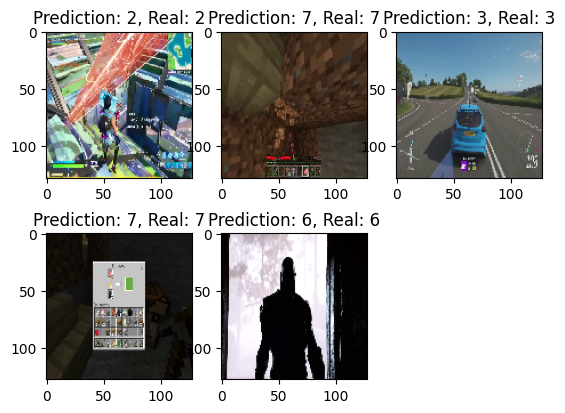

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Obtain a batch of test data
test_images, test_labels = next(test_generator)

# Make predictions with the model
predictions = model.predict(test_images)

# Show 5 images with their predictions
for i in range(1, 6):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns, plot number i
    plt.imshow(test_images[i])
    plt.title(f"Prediction: {np.argmax(predictions[i])}, Real: {np.argmax(test_labels[i])}")

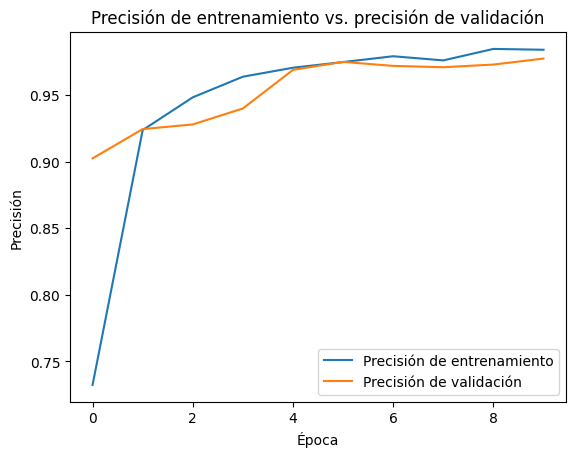

In [23]:
# Graficar precisión de entrenamiento vs. precisión de validación
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento vs. precisión de validación')
plt.show()